In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Define the path to the directory containing the spectrogram images
spectrogram_dir = '10sec_augmented_spectrogram_images'

# Define the model hyperparameters
input_shape = (64, 64, 3)  # Adjust the dimensions as per your spectrogram size
num_classes = len(os.listdir(spectrogram_dir))  # Assuming subdirectories represent genres

# Load spectrogram images and labels
spectrograms = []
labels = []

for genre_folder in os.listdir(spectrogram_dir):
    genre_dir = os.path.join(spectrogram_dir, genre_folder)
    for filename in os.listdir(genre_dir):
        if filename.endswith('.png'):
            filepath = os.path.join(genre_dir, filename)
            spectrogram = tf.keras.preprocessing.image.load_img(filepath, target_size=(input_shape[0], input_shape[1]))
            spectrogram = tf.keras.preprocessing.image.img_to_array(spectrogram)
            spectrogram /= 255.0  # Normalize pixel values to [0, 1]
            spectrograms.append(spectrogram)
            labels.append(genre_folder)


# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Sort the data by labels
sorting_indices = np.argsort(labels_encoded)
spectrograms = np.array(spectrograms)[sorting_indices]
labels_encoded = labels_encoded[sorting_indices]

num_classes = len(label_encoder.classes_)

labels_one_hot = to_categorical(labels_encoded, num_classes=num_classes)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(spectrograms, labels_one_hot, test_size=0.2, random_state=42)


In [ ]:
spectrograms.shape

(11964, 64, 64, 3)

In [ ]:
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def model_evaluation_report(model):

  # Evaluate the model on the test data
  y_pred = model.predict(x_test)
  y_pred_classes = np.argmax(y_pred, axis=1)

  # Inverse transform encoded labels to original labels
  y_test_original = label_encoder.inverse_transform(y_test.argmax(axis=1))
  y_pred_original = label_encoder.inverse_transform(y_pred_classes)

  # Print classification report
  print(classification_report(y_test_original, y_pred_original))

  # Plot the confusion matrix
  conf_matrix = confusion_matrix(y_test_original, y_pred_original)
  plt.figure(figsize=(10, 8))
  sns.heatmap(conf_matrix, cmap='Blues',  annot=True)
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.xticks(np.arange(len(label_encoder.classes_)), label_encoder.classes_, rotation=90)
  plt.yticks(np.arange(len(label_encoder.classes_)), label_encoder.classes_)
  plt.show()

  # Plot accuracy and loss curves
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  best_val_accuracy = max(history.history['val_accuracy'])
  plt.axvline(np.argmax(history.history['val_accuracy']), color='r', linestyle='--', label=f'Best Val Acc ({best_val_accuracy:.4f})')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.axvline(np.argmin(history.history['val_loss']), color='r', linestyle='--', label='Best Val Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()

CNN model

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))


model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))


model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))


model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))


# Define a ModelCheckpoint callback to save the entire model (including architecture and weights)
model_checkpoint = ModelCheckpoint('CNN_spectrogram_10sec_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Train the model with callbacks
history = model.fit(x_train, y_train, epochs=150, batch_size=128, validation_data=(x_test, y_test), callbacks=[model_checkpoint])


# Evaluate the best model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc * 100:.2f}%')


Epoch 1/150
75/75 [==============================] - ETA: 0s - loss: 2.2543 - accuracy: 0.1386
Epoch 1: val_accuracy improved from -inf to 0.27957, saving model to CNN_model_10_sec.h5
75/75 [==============================] - 5s 31ms/step - loss: 2.2543 - accuracy: 0.1386 - val_loss: 2.0516 - val_accuracy: 0.2796
Epoch 2/150
74/75 [============================>.] - ETA: 0s - loss: 1.9016 - accuracy: 0.2923
Epoch 2: val_accuracy improved from 0.27957 to 0.35855, saving model to CNN_model_10_sec.h5
75/75 [==============================] - 2s 29ms/step - loss: 1.9003 - accuracy: 0.2926 - val_loss: 1.7364 - val_accuracy: 0.3585
Epoch 3/150
73/75 [============================>.] - ETA: 0s - loss: 1.6828 - accuracy: 0.3728
Epoch 3: val_accuracy improved from 0.35855 to 0.40869, saving model to CNN_model_10_sec.h5
75/75 [==============================] - 2s 31ms/step - loss: 1.6812 - accuracy: 0.3735 - val_loss: 1.5790 - val_accuracy: 0.4087
Epoch 4/150
73/75 [============================>.] -

In [ ]:
# Evaluate the best model
# Get the best model's index from the validation accuracy
best_model_index = np.argmax(history.history['val_accuracy'])
best_model_val_accuracy = history.history['val_accuracy'][best_model_index]
best_model_loss = history.history['loss'][best_model_index]
best_model_accuracy = history.history['accuracy'][best_model_index]
best_model_val_loss = history.history['val_loss'][best_model_index]

print(f"Best Model Metrics:")
print(f"Accuracy: {best_model_accuracy:.4f}")
print(f"Validation Accuracy: {best_model_val_accuracy:.4f}")
print(f"Loss: {best_model_loss:.4f}")
print(f"Validation Loss: {best_model_val_loss:.4f}")

Best Model Metrics:
Accuracy: 0.8967
Validation Accuracy: 0.9156
Loss: 0.3027
Validation Loss: 0.2710


75/75 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

       blues       0.92      0.94      0.93       247
   classical       0.94      0.97      0.96       234
     country       0.89      0.92      0.91       236
       disco       0.90      0.89      0.89       252
      hiphop       0.92      0.93      0.93       247
        jazz       0.94      0.92      0.93       229
       metal       0.97      0.94      0.95       247
         pop       0.94      0.87      0.90       251
      reggae       0.90      0.94      0.92       218
        rock       0.83      0.84      0.83       232

    accuracy                           0.92      2393
   macro avg       0.92      0.92      0.92      2393
weighted avg       0.92      0.92      0.92      2393



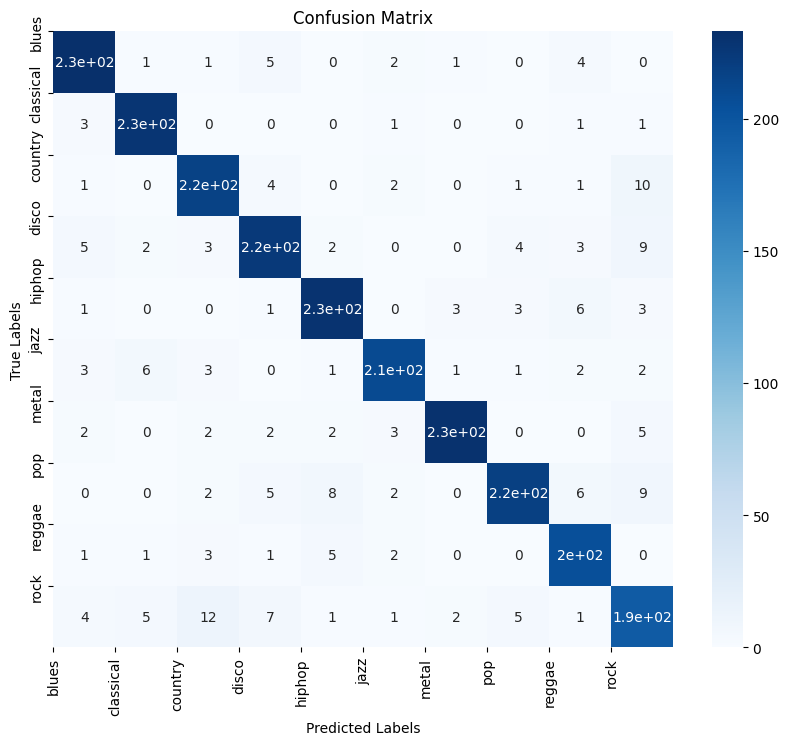

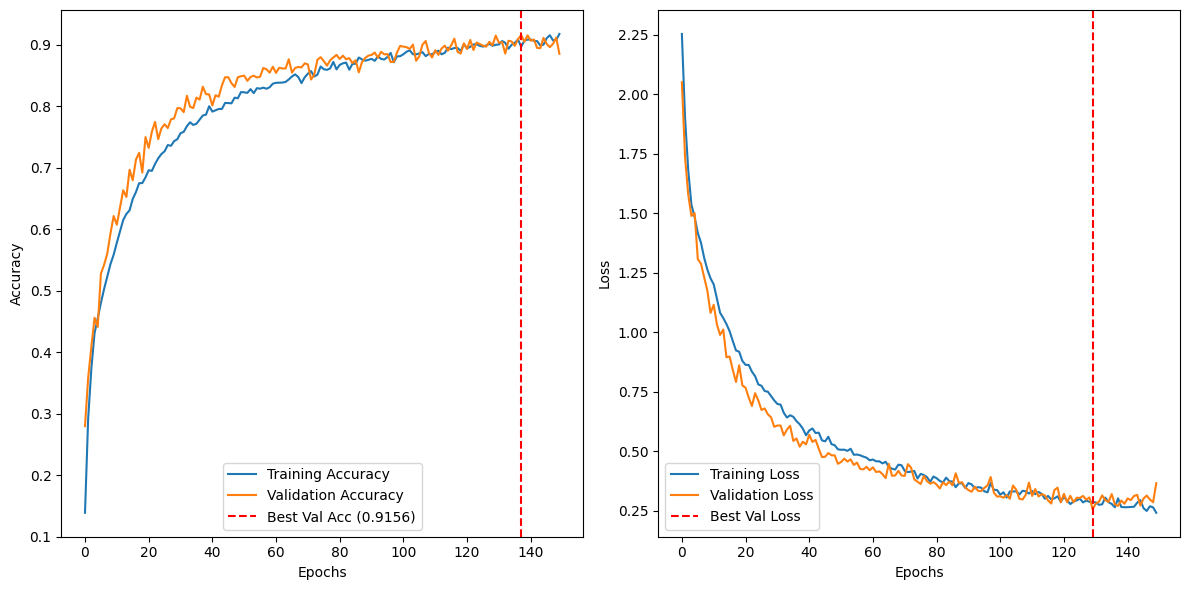

In [ ]:
# Load the saved model
model = tf.keras.models.load_model('CNN_spectrogram_10sec_model.h5')
model_evaluation_report(model)

## GRU models

In [ ]:
# Build the CRNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

# Add recurrent layers (GRU)
model.add(layers.Reshape((-1, np.prod(model.layers[-1].output_shape[1:]))))  # Flatten the spatial dimensions
model.add(layers.GRU(32, return_sequences=True))
model.add(layers.GRU(32))

model.add(layers.Dropout(0.3))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

# Define a ModelCheckpoint callback to save the entire model (including architecture and weights)
model_checkpoint = ModelCheckpoint('GRU_spectrogram_10sec_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with callbacks
history = model.fit(x_train, y_train, epochs=170, batch_size=128, validation_data=(x_test, y_test), callbacks=[model_checkpoint])

# Evaluate the best model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc * 100:.2f}%')

Epoch 1/170
74/75 [============================>.] - ETA: 0s - loss: 2.2273 - accuracy: 0.1463
Epoch 1: val_accuracy improved from -inf to 0.23903, saving model to GRU_model_10_sec.h5
75/75 [==============================] - 9s 43ms/step - loss: 2.2253 - accuracy: 0.1482 - val_loss: 2.0999 - val_accuracy: 0.2390
Epoch 2/170
75/75 [==============================] - ETA: 0s - loss: 1.9314 - accuracy: 0.2824
Epoch 2: val_accuracy improved from 0.23903 to 0.31550, saving model to GRU_model_10_sec.h5
75/75 [==============================] - 3s 34ms/step - loss: 1.9314 - accuracy: 0.2824 - val_loss: 1.8283 - val_accuracy: 0.3155
Epoch 3/170
75/75 [==============================] - ETA: 0s - loss: 1.7328 - accuracy: 0.3480
Epoch 3: val_accuracy improved from 0.31550 to 0.35771, saving model to GRU_model_10_sec.h5
75/75 [==============================] - 2s 27ms/step - loss: 1.7328 - accuracy: 0.3480 - val_loss: 1.7434 - val_accuracy: 0.3577
Epoch 4/170
73/75 [============================>.] -

In [ ]:
# Evaluate the best model
# Get the best model's index from the validation accuracy
best_model_index = np.argmax(history.history['val_accuracy'])
best_model_val_accuracy = history.history['val_accuracy'][best_model_index]
best_model_loss = history.history['loss'][best_model_index]
best_model_accuracy = history.history['accuracy'][best_model_index]
best_model_val_loss = history.history['val_loss'][best_model_index]

print(f"Best Model Metrics:")
print(f"Accuracy: {best_model_accuracy:.4f}")
print(f"Validation Accuracy: {best_model_val_accuracy:.4f}")
print(f"Loss: {best_model_loss:.4f}")
print(f"Validation Loss: {best_model_val_loss:.4f}")

Best Model Metrics:
Accuracy: 0.9051
Validation Accuracy: 0.9018
Loss: 0.2853
Validation Loss: 0.3335


75/75 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

       blues       0.92      0.92      0.92       247
   classical       0.95      0.94      0.95       234
     country       0.87      0.91      0.89       236
       disco       0.91      0.87      0.89       252
      hiphop       0.87      0.96      0.91       247
        jazz       0.88      0.91      0.89       229
       metal       0.97      0.92      0.95       247
         pop       0.86      0.89      0.87       251
      reggae       0.92      0.89      0.91       218
        rock       0.86      0.81      0.84       232

    accuracy                           0.90      2393
   macro avg       0.90      0.90      0.90      2393
weighted avg       0.90      0.90      0.90      2393



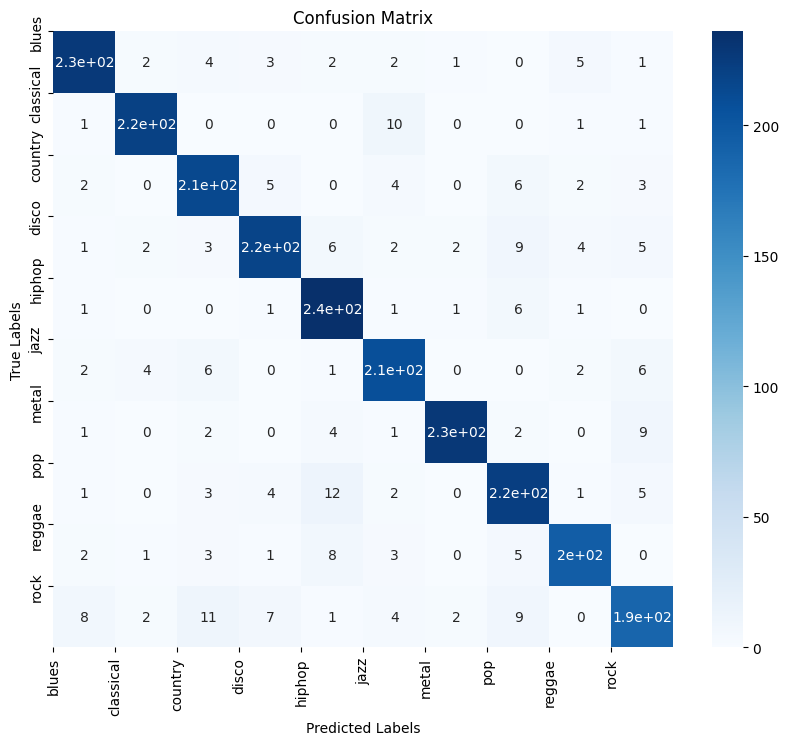

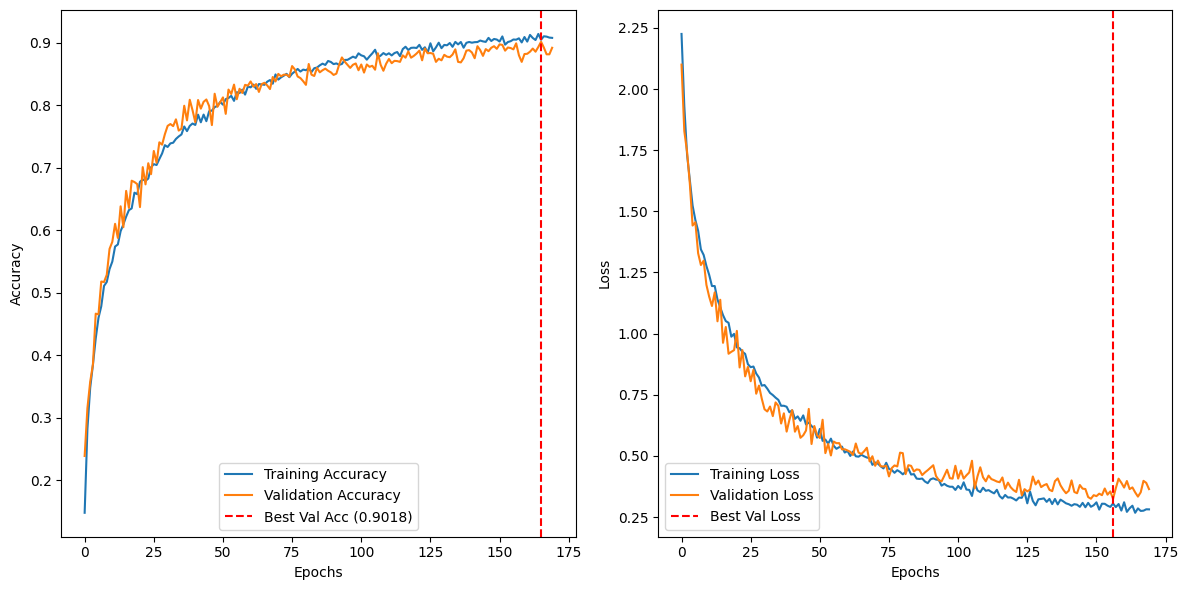

In [ ]:
# Load the saved model
model = tf.keras.models.load_model('GRU_spectrogram_10sec_model.h5')
model_evaluation_report(model)

## lstm models

In [ ]:
# Build the CRNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))

# Add recurrent layers (LSTM)
model.add(layers.Reshape((-1, np.prod(model.layers[-1].output_shape[1:]))))  # Flatten the spatial dimensions
model.add(layers.LSTM(32, return_sequences=True))
model.add(layers.LSTM(32))

model.add(layers.Dropout(0.3))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

# Define a ModelCheckpoint callback to save the entire model (including architecture and weights)
model_checkpoint = ModelCheckpoint('LSTM_spectrogram_10sec_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with callbacks
history = model.fit(x_train, y_train, epochs=250, batch_size=128, validation_data=(x_test, y_test), callbacks=[model_checkpoint])


Epoch 1/250
73/75 [============================>.] - ETA: 0s - loss: 2.2784 - accuracy: 0.1187
Epoch 1: val_accuracy improved from -inf to 0.18178, saving model to LSTM_model_10_sec.h5
75/75 [==============================] - 8s 45ms/step - loss: 2.2756 - accuracy: 0.1199 - val_loss: 2.1518 - val_accuracy: 0.1818
Epoch 2/250
73/75 [============================>.] - ETA: 0s - loss: 2.0796 - accuracy: 0.2137
Epoch 2: val_accuracy improved from 0.18178 to 0.27998, saving model to LSTM_model_10_sec.h5
75/75 [==============================] - 2s 33ms/step - loss: 2.0782 - accuracy: 0.2147 - val_loss: 1.9844 - val_accuracy: 0.2800
Epoch 3/250
73/75 [============================>.] - ETA: 0s - loss: 1.9037 - accuracy: 0.2929
Epoch 3: val_accuracy improved from 0.27998 to 0.29043, saving model to LSTM_model_10_sec.h5
75/75 [==============================] - 2s 28ms/step - loss: 1.9005 - accuracy: 0.2935 - val_loss: 1.8866 - val_accuracy: 0.2904
Epoch 4/250
75/75 [==============================

In [ ]:
# Evaluate the best model
# Get the best model's index from the validation accuracy
best_model_index = np.argmax(history.history['val_accuracy'])
best_model_val_accuracy = history.history['val_accuracy'][best_model_index]
best_model_loss = history.history['loss'][best_model_index]
best_model_accuracy = history.history['accuracy'][best_model_index]
best_model_val_loss = history.history['val_loss'][best_model_index]

print(f"Best Model Metrics:")
print(f"Accuracy: {best_model_accuracy:.4f}")
print(f"Validation Accuracy: {best_model_val_accuracy:.4f}")
print(f"Loss: {best_model_loss:.4f}")
print(f"Validation Loss: {best_model_val_loss:.4f}")

Best Model Metrics:
Accuracy: 0.9031
Validation Accuracy: 0.8976
Loss: 0.3053
Validation Loss: 0.3270


75/75 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

       blues       0.92      0.94      0.93       247
   classical       0.91      0.97      0.94       234
     country       0.89      0.88      0.88       236
       disco       0.88      0.83      0.86       252
      hiphop       0.96      0.85      0.90       247
        jazz       0.91      0.90      0.91       229
       metal       0.91      0.96      0.93       247
         pop       0.87      0.89      0.88       251
      reggae       0.89      0.89      0.89       218
        rock       0.83      0.87      0.85       232

    accuracy                           0.90      2393
   macro avg       0.90      0.90      0.90      2393
weighted avg       0.90      0.90      0.90      2393



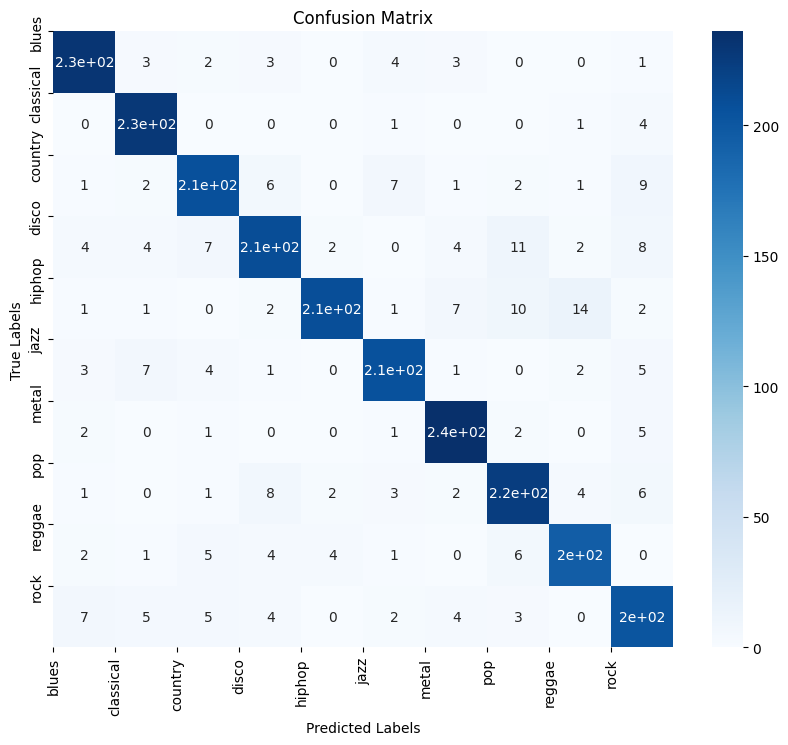

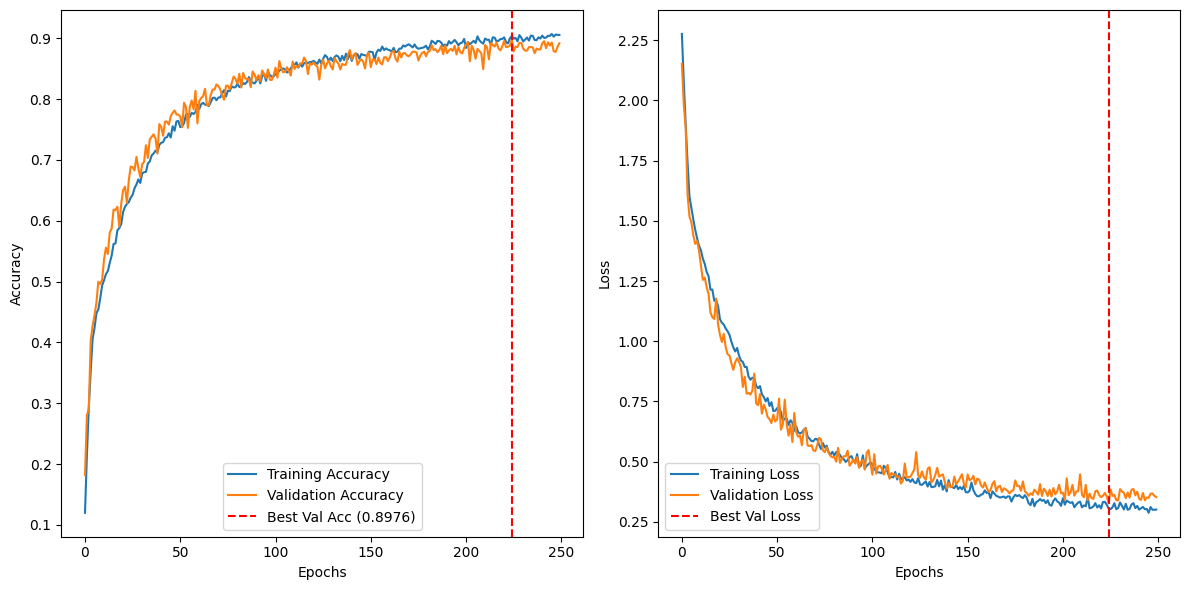

In [ ]:
# Load the saved model
model = tf.keras.models.load_model('LSTM_spectrogram_10sec_model.h5')
model_evaluation_report(model)